## Notes

### Overview
This notebook captures a series of efforts to apply signal processing techniques to imu sensor data recorded from a small 4-wheel motor-driven car.  The main objectives are:
- Demonstrate a data processing pipeline that can estimate vehicle position from measurements of acceleration estimates

### TODO
- Rerun test with 10ms sampling interval (might be missing some acceleration)
- Naive running average
- Trailing n-sample average
- FIR vs. IIR high pass
- FIR vs. IIR band pass

In [48]:
%matplotlib inline
from __future__ import division
import time
import datetime
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

In [24]:
# - Plotting helper for several experiments
def plot_raw_and_processed_data(
    raw_data,
    filtered_data=None,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    do_filtered_data = False
    if filtered_data is not None:
        do_filtered_data = True
        filt_data_x = filtered_data.x
        filt_data_y = filtered_data.y
        filt_data_z = filtered_data.z
    
    sig_data_x = raw_data.x
    sig_data_y = raw_data.y
    sig_data_z = raw_data.z

    

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(sig_data_x, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_x, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - X', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    current_axes.legend(loc='upper left')

    current_axes = axes[1]
    current_axes.plot(sig_data_y, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_y, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Y', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    current_axes.legend(loc='upper left')

    current_axes = axes[2]
    current_axes.plot(sig_data_z, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filt_data_z, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Z', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    current_axes.legend(loc='upper left')

In [95]:
data_path = '/home/pi/nanibot/sandboxes/data/'

#data_name = 'rover_imu_test_data_Test3d_20170110_035946.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_040156.csv'
data_name = 'rover_imu_test_data_Test3d_20170110_040330.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_040605.csv'
#data_name = 'rover_imu_test_data_Test3d_20170110_041017.csv'

raw_data = pd.read_csv(data_path+data_name)
#raw_data

### Raw Data

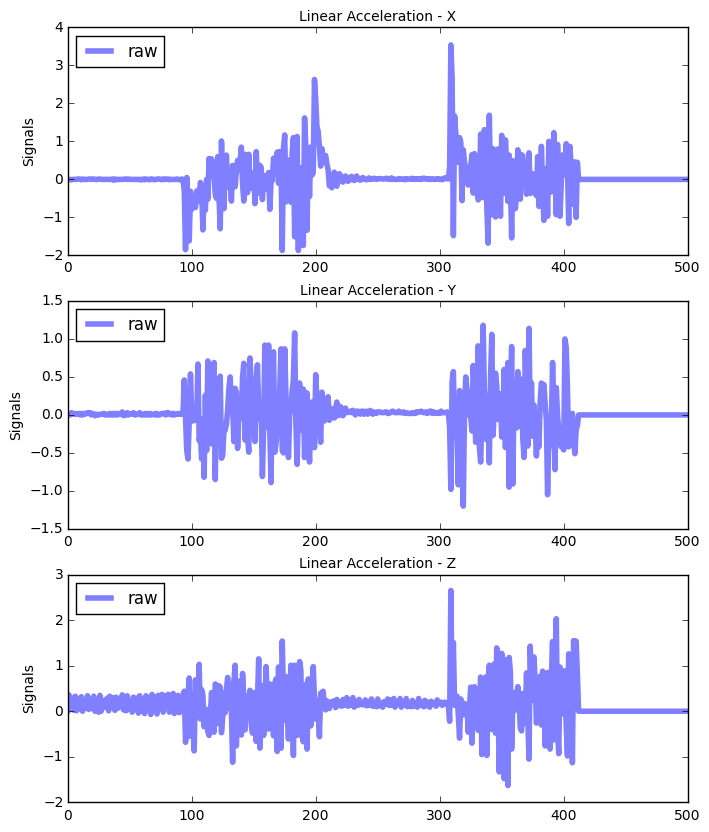

In [96]:
plot_raw_and_processed_data(raw_data,filtered_data=None,y1lim=None,y2lim=None,y3lim=None)

### Cumulative Sum

In [101]:
filtered_data = raw_data.cumsum()

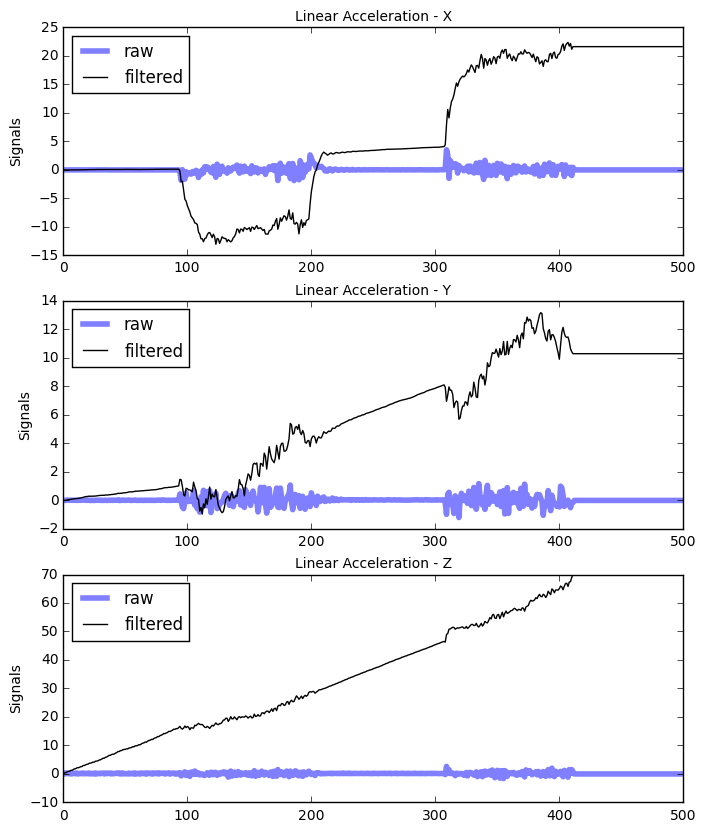

In [102]:
plot_raw_and_processed_data(raw_data,filtered_data=filtered_data,y1lim=None,y2lim=None,y3lim=None)

### Band Pass - FIR

In [164]:
fs = 1/0.02
nyq = 0.5 * fs
ntaps = 32
window = 'hamming'
lowcut = 0.05 * nyq
highcut = 0.99 * nyq
b = signal.firwin(ntaps, [lowcut, highcut], nyq=nyq, pass_zero=False,window=window, scale=False)
a = 1

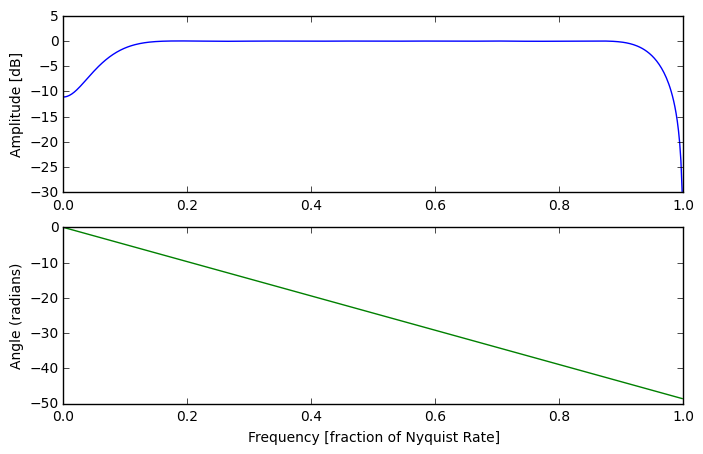

In [165]:
w, h = signal.freqz(b, a)

fig, axes = plt.subplots(figsize=(8,5),nrows=2, ncols=1)
current_axes = axes[0]
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])

angles = np.unwrap(np.angle(h))
current_axes = axes[1]
current_axes.plot(w/math.pi, angles, 'g')
current_axes.set_ylabel('Angle (radians)', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=10)

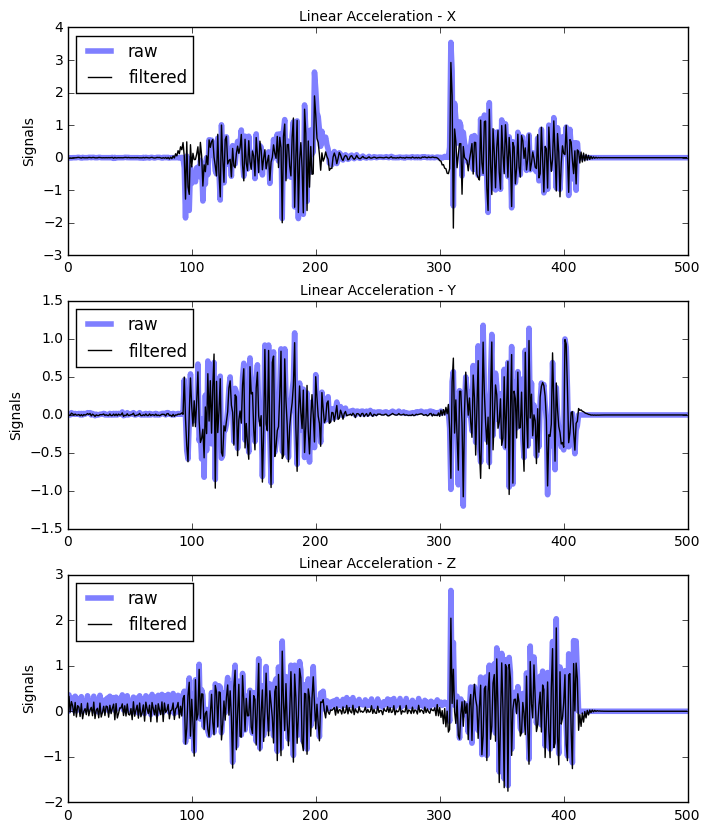

In [166]:
padtype = 'odd'
#method = 'gust'
method = 'pad'
filt_data_x = signal.filtfilt(b,a,raw_data.x,padtype=padtype,padlen=256,method=method)
filt_data_y = signal.filtfilt(b,a,raw_data.y,padtype=padtype,padlen=256,method=method)
filt_data_z = signal.filtfilt(b,a,raw_data.z,padtype=padtype,padlen=256,method=method)

filtered_data = pd.DataFrame({'x':filt_data_x,'y':filt_data_y,'z':filt_data_z})
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data,y1lim=None,y2lim=None,y3lim=None)

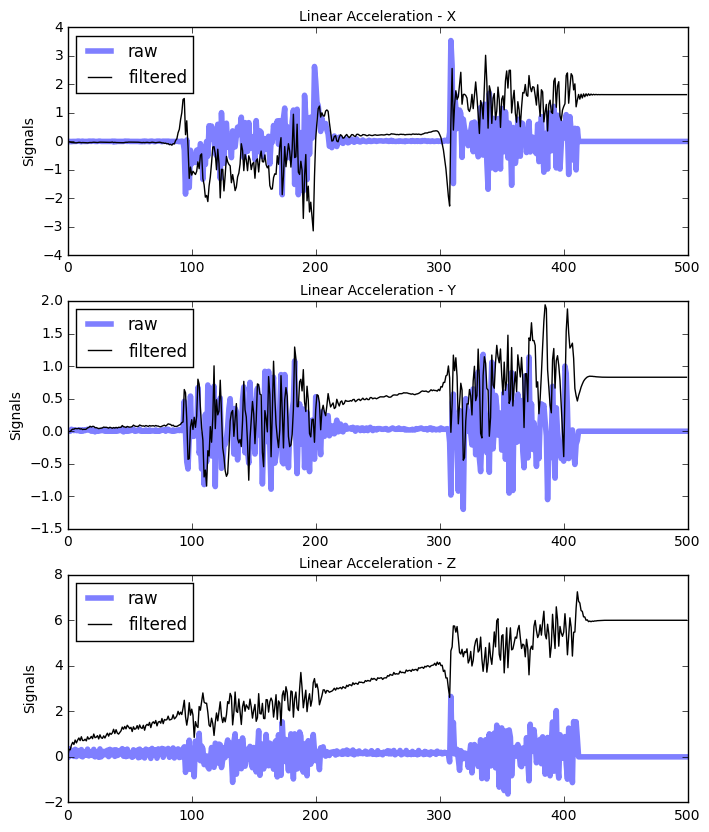

In [167]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data.cumsum())

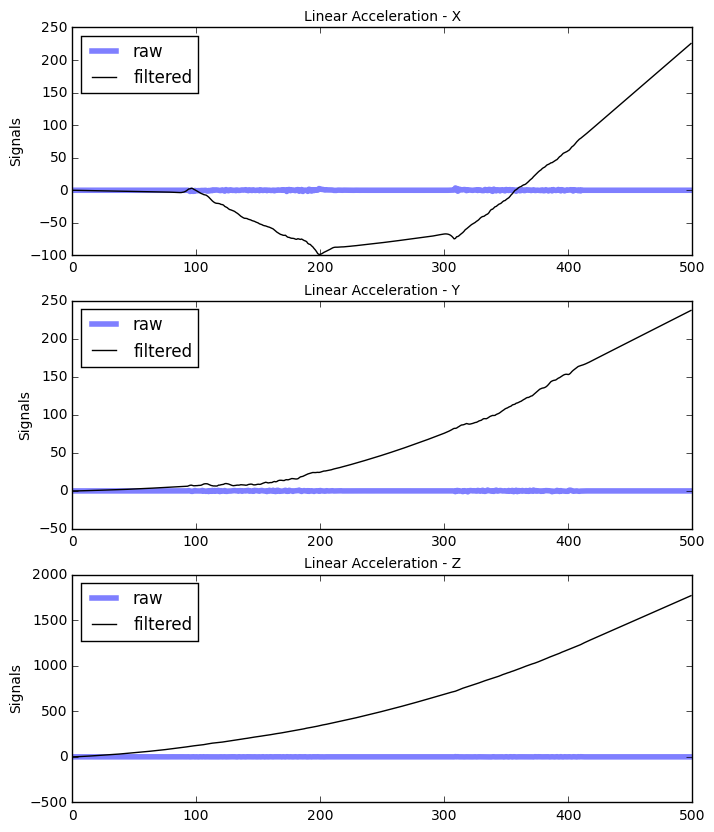

In [168]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data.cumsum().cumsum())

### Band Pass - IIR

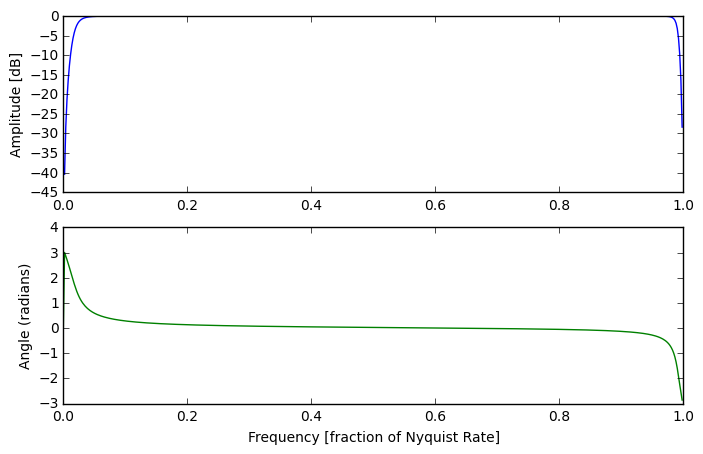

In [237]:
b, a = signal.butter(2, [0.02,0.99], 'bandpass', analog=False)
w, h = signal.freqz(b, a)

fig, axes = plt.subplots(figsize=(8,5),nrows=2, ncols=1)
current_axes = axes[0]
current_axes.plot(w/math.pi, 20 * np.log10(abs(h)), 'b')
current_axes.set_ylabel('Amplitude [dB]', fontsize=10)
#current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=8)
#current_axes.set_ylim([-500,50])

angles = np.unwrap(np.angle(h))
current_axes = axes[1]
current_axes.plot(w/math.pi, angles, 'g')
current_axes.set_ylabel('Angle (radians)', fontsize=10)
current_axes.set_xlabel('Frequency [fraction of Nyquist Rate]', fontsize=10)

In [238]:
padlen = 32
filt_data_x = signal.filtfilt(b,a,raw_data.x,padtype='odd',padlen=padlen)
filt_data_y = signal.filtfilt(b,a,raw_data.y,padtype='odd',padlen=padlen)
filt_data_z = signal.filtfilt(b,a,raw_data.z,padtype='odd',padlen=padlen)

filtered_data = pd.DataFrame({'x':filt_data_x,'y':filt_data_y,'z':filt_data_z})

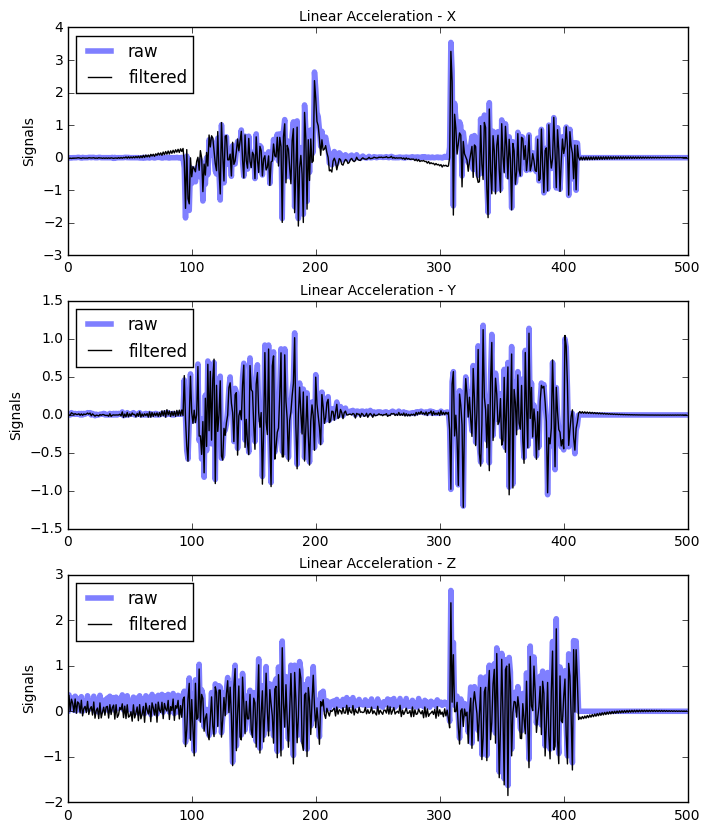

In [239]:
plot_raw_and_processed_data(raw_data,filtered_data=filtered_data,y1lim=None,y2lim=None,y3lim=None)

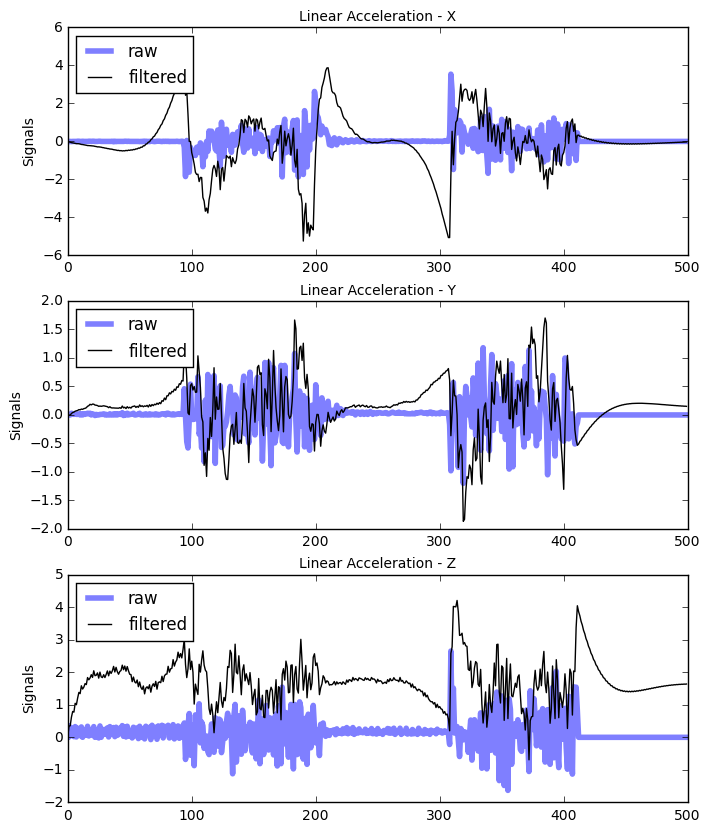

In [240]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data.cumsum())

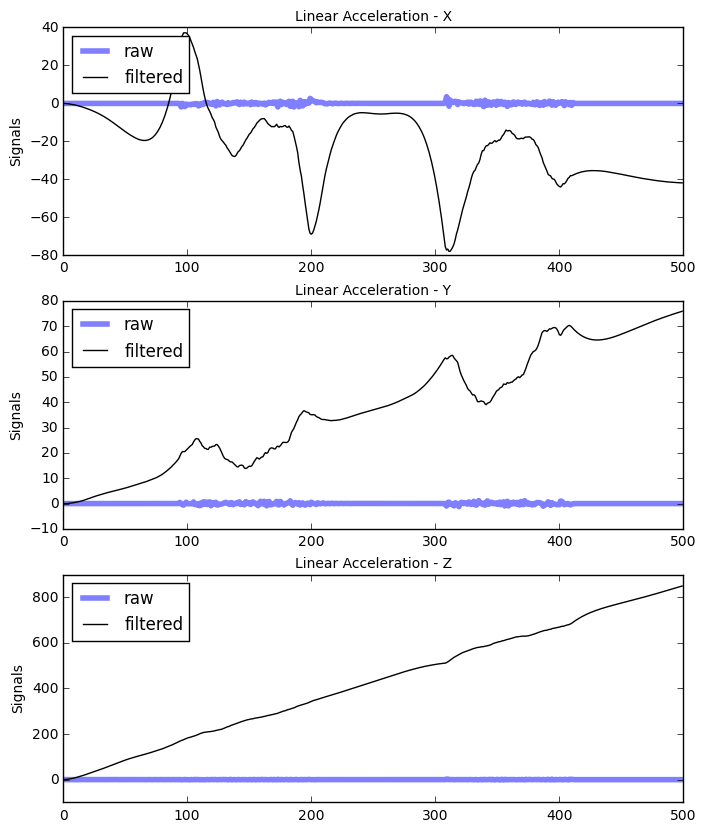

In [241]:
plot_raw_and_processed_data(
    raw_data,
    filtered_data=filtered_data.cumsum().cumsum())